In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [0]:
mkdir 'data1'

In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'


In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    file_name = 'data1/' + file_name[41:]
    
    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Grouping all texts files
A dataframe is first created to keep individual files at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#list of the file names
files_list = os.listdir('data1')

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [0]:
# for verification purposes later, count the nr of characters for each content
sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
sources['file_len'].sum()

1779770

In [0]:
# variable containing the documents separately
corpus = sources['file_content']

In [0]:
# variable containing all documents together
all_texts = ''
for i in range(len(sources)):
  all_texts += sources['file_content'][i]

In [0]:
# check length
len(all_texts)

1779770


## 1.2 Removing stop words, punctuation, short words

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# add new column in df with processed tokens
sources['tokens_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalnum() and len(w) > 3 )])

In [0]:
# these lines are useful if we want to provide alternate stop words lists (NLTK)
# show list of default NLTK Italian stopwords
# stopwords.words('italian')
# ital_stopwords = stopwords.words('italian')
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
import spacy
from spacy.lang.it.stop_words import STOP_WORDS

In [0]:
spacy_it_sw = STOP_WORDS

In [0]:
# add column with tokenized documents without sw
sources['tokens_prep_nostop'] = sources['tokens_prep'].apply(lambda x: [w for w in x if not w in spacy_it_sw])

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
# add column with stemmed tokens
sources['tokens_stemmed'] = sources['tokens_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.4 Lemmatize

In [0]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [0]:
!python -m spacy download it_core_news_sm

     |████████████████████████████████| 14.5MB 3.7MB/s 
  Created wheel for it-core-news-sm: filename=it_core_news_sm-2.2.5-cp36-none-any.whl size=14471130 sha256=ccc94a846a808d177cde3f6e1c0d8e4eeb66619860a325ad6b7003de6a5ebafd
  Stored in directory: /tmp/pip-ephem-wheel-cache-cb9ajnqp/wheels/a1/01/c2/127ab92cc5e3c7f36b5cd4bff28d1c29c313962a2ba913e720
Successfully built it-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')


In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [0]:
# add column with lemmatized tokens
sources['tokens_lemmatized'] = sources['tokens_prep_nostop'].apply(lambda x: lemmatize(x))

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = sources['tokens_lemmatized']

# 2. Topics with LDA

In [0]:
# installation setup that works for Mallet: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [0]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-05-13 06:56:54--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  13.1MB/s    in 1.2s    

2020-05-13 06:56:55 (13.1 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA

### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [0]:
# create a human friendly view of term frequency list
# I leave the line below for testing purposes
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1000]]

In [0]:
# list of words and frequency
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [0]:
#testing
#for cp in corpus[:10]:
#  word_id = list(cp[0])[0]
#  print (id2word[list(cp[0])[0]])
#  print (list(cp[0])[1])

In [0]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [0]:
# sort descending
words_frequency.sort_values(by=['frequency'], ascending=False)[:10]
# I think it gives the frequency on a per document basis (further testing needed)

,word,frequency
83,1903,5
45,altro,3
78,1903,3
60,alcun,3
19,accompagnare,3
15,1903,2
77,accompagnare,2
80,accompagnare,2
67,1903,2
86,accompagnare,2


### 2.1.2 TFIDF

In [0]:
# optional
# TFIDF for better performance
# https://en.wikipedia.org/wiki/Tf–idf / 
# https://rare-technologies.com/pivoted-document-length-normalisation/

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## 2.2 LDA

In [0]:
# set the number of topics here
numtopics = 5

### 2.2.1 LDA with Gensim and without TFIDF

In [0]:
ldagensim = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)

In [0]:
ldagensim.print_topics()

[(0,
  '0.008*"italiano" + 0.003*"dispaccio" + 0.003*"italia" + 0.003*"potere" + 0.003*"telegrafico" + 0.003*"venire" + 0.003*"daily" + 0.002*"roma" + 0.002*"giornale" + 0.002*"cardinale"'),
 (1,
  '0.006*"italiano" + 0.004*"italia" + 0.004*"roma" + 0.004*"dispaccio" + 0.003*"potere" + 0.003*"telegrafico" + 0.003*"daily" + 0.002*"venire" + 0.002*"giornale" + 0.002*"nuovo"'),
 (2,
  '0.011*"italiano" + 0.005*"italia" + 0.004*"roma" + 0.004*"dispaccio" + 0.003*"telegrafico" + 0.003*"venire" + 0.003*"giornale" + 0.003*"daily" + 0.002*"potere" + 0.002*"cardinale"'),
 (3,
  '0.004*"italiano" + 0.003*"roma" + 0.003*"italia" + 0.003*"telegrafico" + 0.003*"dispaccio" + 0.002*"cardinale" + 0.002*"daily" + 0.002*"venire" + 0.002*"potere" + 0.002*"giornale"'),
 (4,
  '0.007*"italiano" + 0.004*"dispaccio" + 0.003*"italia" + 0.003*"potere" + 0.003*"telegrafico" + 0.003*"roma" + 0.003*"venire" + 0.003*"giornale" + 0.003*"cardinale" + 0.002*"americano"')]

### 2.2.2 LDA with Gensim and TFIDF



In [0]:
ldagensim_tfidf = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=numtopics)

In [0]:
ldagensim_tfidf.print_topics()

[(0,
  '0.000*"cardinale" + 0.000*"ebreo" + 0.000*"black" + 0.000*"marconi" + 0.000*"mayor" + 0.000*"diamond" + 0.000*"maggio" + 0.000*"serbia" + 0.000*"lavoratore" + 0.000*"conclave"'),
 (1,
  '0.000*"cardinale" + 0.000*"text" + 0.000*"available" + 0.000*"papa" + 0.000*"xiii" + 0.000*"leone" + 0.000*"conclave" + 0.000*"pontefice" + 0.000*"oreglia" + 0.000*"riduzione"'),
 (2,
  '0.000*"marconi" + 0.000*"cardinale" + 0.000*"maggio" + 0.000*"conclave" + 0.000*"terno" + 0.000*"socialisto" + 0.000*"ferro" + 0.000*"pietro" + 0.000*"tolstoi" + 0.000*"papa"'),
 (3,
  '0.000*"cardinale" + 0.000*"leone" + 0.000*"xiii" + 0.000*"marconi" + 0.000*"serbia" + 0.000*"papa" + 0.000*"conclave" + 0.000*"pontefice" + 0.000*"francia" + 0.000*"alessandro"'),
 (4,
  '0.000*"cardinale" + 0.000*"marconi" + 0.000*"black" + 0.000*"diamond" + 0.000*"tolstoi" + 0.000*"california" + 0.000*"serbia" + 0.000*"immigrare" + 0.000*"guglielmo" + 0.000*"roosevelt"')]

### 2.2.3 LDA with Mallet, without TFIDF

In [0]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
ldamallet.print_topics()

[(0,
  '0.015*"cardinale" + 0.012*"papa" + 0.010*"roma" + 0.009*"italiano" + 0.006*"chiesa" + 0.006*"pontefice" + 0.006*"vaticano" + 0.005*"nome" + 0.005*"leone" + 0.005*"venire"'),
 (1,
  '0.008*"leggere" + 0.008*"potere" + 0.006*"dovere" + 0.005*"società" + 0.005*"popolare" + 0.005*"passare" + 0.004*"credere" + 0.004*"perchè" + 0.004*"nuovo" + 0.004*"diritto"'),
 (2,
  '0.011*"dispaccio" + 0.007*"telegrafico" + 0.006*"parigi" + 0.006*"giugno" + 0.005*"pubblico" + 0.005*"venire" + 0.005*"ufficiale" + 0.004*"rimanere" + 0.004*"notizia" + 0.004*"dire"'),
 (3,
  '0.021*"italiano" + 0.012*"italia" + 0.007*"potere" + 0.007*"york" + 0.005*"dare" + 0.005*"unito" + 0.005*"grande" + 0.005*"pubblicare" + 0.005*"americano" + 0.005*"operare"'),
 (4,
  '0.012*"italiano" + 0.009*"dispaccio" + 0.009*"giornale" + 0.008*"roma" + 0.007*"telegrafico" + 0.007*"daily" + 0.006*"maggio" + 0.005*"gran" + 0.005*"italia" + 0.005*"presidente"')]

### 2.2.4 LDA with Mallet with TFIDF

In [0]:
# !Apparently this approach doesn't work with the Mallet wrapper
# https://groups.google.com/forum/#!topic/gensim/XDcdzM9vtmQ

In [0]:
ldamallet_tfidf = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=numtopics, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
ldamallet_tfidf.print_topics()

/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/ldamallet.py:442: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist


[(0,
  'nan*"parecehl" + nan*"partiiolarl" + nan*"orric" + nan*"pagr8" + nan*"paikret" + nan*"pareatl" + nan*"ornala" + nan*"peraio" + nan*"pauisimn" + nan*"onnipo"'),
 (1,
  'nan*"parecehl" + nan*"partiiolarl" + nan*"orric" + nan*"pagr8" + nan*"paikret" + nan*"pareatl" + nan*"ornala" + nan*"peraio" + nan*"pauisimn" + nan*"onnipo"'),
 (2,
  'nan*"parecehl" + nan*"partiiolarl" + nan*"orric" + nan*"pagr8" + nan*"paikret" + nan*"pareatl" + nan*"ornala" + nan*"peraio" + nan*"pauisimn" + nan*"onnipo"'),
 (3,
  'nan*"parecehl" + nan*"partiiolarl" + nan*"orric" + nan*"pagr8" + nan*"paikret" + nan*"pareatl" + nan*"ornala" + nan*"peraio" + nan*"pauisimn" + nan*"onnipo"'),
 (4,
  'nan*"parecehl" + nan*"partiiolarl" + nan*"orric" + nan*"pagr8" + nan*"paikret" + nan*"pareatl" + nan*"ornala" + nan*"peraio" + nan*"pauisimn" + nan*"onnipo"')]

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

### 2.3.1 Coherence score LDA Gensim without TFIDF

In [0]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.45713168419834027


### 2.3.2 Coherence score LDA Gensim with TFIDF

In [0]:
coherence_model_ldagensim_tfidf = CoherenceModel(model=ldagensim_tfidf, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim_tfidf = coherence_model_ldagensim_tfidf.get_coherence()
print('\nCoherence Score LDA Gensim TFIDF: ', coherence_ldagensim_tfidf)


Coherence Score LDA Gensim TFIDF:  0.39283971724985467


### 2.3.1 Coherence score LDA Mallet


In [0]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score LDA MAllet: ', coherence_ldamallet)


Coherence Score LDA MAllet:  0.3868305042650206


### 2.3.1 Coherence score LDA Mallet with TFIDF

In [0]:
# coherence score LDA with TFIDF (5 topics)
coherence_model_ldamallet_tfidf = CoherenceModel(model=ldamallet_tfidf, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet_tfidf = coherence_model_ldamallet_tfidf.get_coherence()
print('\nCoherence Score LDA Mallet TFIDF: ', coherence_ldamallet_tfidf)


Coherence Score LDA Mallet TFIDF:  0.6899070873639183


/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


## 2.4 Coherence and number of topics

### 2.4.1 Without TFIDF

In [0]:
# Function to calculate optimal number of topics for LDA Gensim
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# the cell below runs the function set just above and can take a long time to run (20-30 min)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmatized_corpus, start=2, limit=40, step=1)


In [0]:
# Store the value of the coherence scores for plotting later
topics_nr = []
topics_scores = []
limit=20; start=2; step=1;
x = range(start, limit, step)

for m, cv in zip(x, coherence_values):
    topics_nr.append(str(m))
    topics_scores.append(round(cv, 4))
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.284
Num Topics = 3  has Coherence Value of 0.2749
Num Topics = 4  has Coherence Value of 0.2939
Num Topics = 5  has Coherence Value of 0.2935
Num Topics = 6  has Coherence Value of 0.2908
Num Topics = 7  has Coherence Value of 0.2874
Num Topics = 8  has Coherence Value of 0.2861
Num Topics = 9  has Coherence Value of 0.2925
Num Topics = 10  has Coherence Value of 0.2902
Num Topics = 11  has Coherence Value of 0.2892
Num Topics = 12  has Coherence Value of 0.2901
Num Topics = 13  has Coherence Value of 0.2833
Num Topics = 14  has Coherence Value of 0.2908
Num Topics = 15  has Coherence Value of 0.2943
Num Topics = 16  has Coherence Value of 0.2911
Num Topics = 17  has Coherence Value of 0.2974
Num Topics = 18  has Coherence Value of 0.2864
Num Topics = 19  has Coherence Value of 0.2973


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

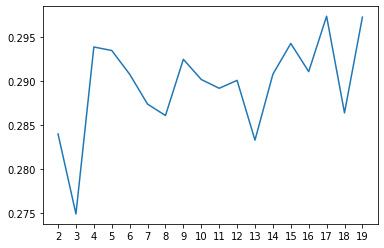

In [0]:
plt.plot(topics_nr, topics_scores)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 17
numtopics = 17
models.LdaModel(corpus, id2word=id2word, num_topics=numtopics).print_topics()

[(0,
  '0.009*"italiano" + 0.004*"roma" + 0.004*"italia" + 0.004*"dispaccio" + 0.003*"venire" + 0.003*"potere" + 0.003*"daily" + 0.003*"telegrafico" + 0.002*"cardinale" + 0.002*"giornale"'),
 (1,
  '0.006*"italiano" + 0.003*"italia" + 0.003*"giornale" + 0.002*"venire" + 0.002*"potere" + 0.002*"cardinale" + 0.002*"telegrafico" + 0.002*"daily" + 0.002*"dire" + 0.002*"roma"'),
 (2,
  '0.007*"italiano" + 0.004*"roma" + 0.004*"italia" + 0.004*"dispaccio" + 0.003*"telegrafico" + 0.003*"venire" + 0.003*"potere" + 0.003*"daily" + 0.003*"giornale" + 0.002*"mentire"'),
 (3,
  '0.007*"italiano" + 0.005*"italia" + 0.004*"dispaccio" + 0.003*"roma" + 0.003*"telegrafico" + 0.003*"potere" + 0.002*"venire" + 0.002*"giornale" + 0.002*"daily" + 0.002*"cardinale"'),
 (4,
  '0.008*"italiano" + 0.004*"italia" + 0.004*"potere" + 0.003*"dispaccio" + 0.003*"roma" + 0.003*"telegrafico" + 0.002*"daily" + 0.002*"venire" + 0.002*"giornale" + 0.002*"nome"'),
 (5,
  '0.008*"italiano" + 0.005*"italia" + 0.004*"roma" 

### 2.4.2 With TFIDF

In [0]:
# Function to calculate optimal number of topics for LDA Gensim
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# the cell below runs the function set just above and can take a long time to run (20-30 min)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=lemmatized_corpus, start=2, limit=40, step=1)


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:807: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [0]:
# Store the value of the coherence scores for plotting later
topics_nr = []
topics_scores = []
limit=20; start=2; step=1;
x = range(start, limit, step)

for m, cv in zip(x, coherence_values):
    topics_nr.append(str(m))
    topics_scores.append(round(cv, 4))
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3032
Num Topics = 3  has Coherence Value of 0.3301
Num Topics = 4  has Coherence Value of 0.3346
Num Topics = 5  has Coherence Value of 0.4466
Num Topics = 6  has Coherence Value of 0.468
Num Topics = 7  has Coherence Value of 0.519
Num Topics = 8  has Coherence Value of 0.4595
Num Topics = 9  has Coherence Value of 0.512
Num Topics = 10  has Coherence Value of 0.5274
Num Topics = 11  has Coherence Value of 0.5062
Num Topics = 12  has Coherence Value of 0.4984
Num Topics = 13  has Coherence Value of 0.5193
Num Topics = 14  has Coherence Value of 0.5304
Num Topics = 15  has Coherence Value of 0.5478
Num Topics = 16  has Coherence Value of 0.5468
Num Topics = 17  has Coherence Value of 0.5163
Num Topics = 18  has Coherence Value of 0.516
Num Topics = 19  has Coherence Value of 0.5309


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

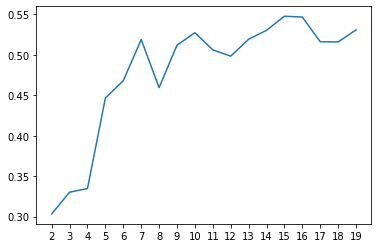

In [0]:
plt.plot(topics_nr, topics_scores)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 7
numtopics = 7
models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=numtopics).print_topics()

[(0,
  '0.000*"cardinale" + 0.000*"studente" + 0.000*"papato" + 0.000*"imperatore" + 0.000*"marconi" + 0.000*"xiii" + 0.000*"milano" + 0.000*"terno" + 0.000*"sezione" + 0.000*"garibaldi"'),
 (1,
  '0.000*"available" + 0.000*"text" + 0.000*"cardinale" + 0.000*"diamond" + 0.000*"black" + 0.000*"pescatore" + 0.000*"conclave" + 0.000*"salmone" + 0.000*"marconi" + 0.000*"cleveland"'),
 (2,
  '0.000*"marconi" + 0.000*"cardinale" + 0.000*"immigrare" + 0.000*"riduzione" + 0.000*"congresso" + 0.000*"papa" + 0.000*"emigrare" + 0.000*"pecel" + 0.000*"regalare" + 0.000*"esplosione"'),
 (3,
  '0.000*"ebreo" + 0.000*"mascagni" + 0.000*"edoardo" + 0.000*"salma" + 0.000*"cardinale" + 0.000*"marconi" + 0.000*"uovo" + 0.000*"eruzione" + 0.000*"miniera" + 0.000*"conclave"'),
 (4,
  '0.000*"cardinale" + 0.000*"tolstoi" + 0.000*"leone" + 0.000*"xiii" + 0.000*"xlll" + 0.000*"sognatore" + 0.000*"papa" + 0.000*"pontefice" + 0.000*"emigrare" + 0.000*"popolo"'),
 (5,
  '0.000*"cardinale" + 0.000*"oreglia" + 0.0

## 2.5 Visualize the topic keywords

In [109]:
# Plotting tools
! pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 18.9MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=de3023c506748edaec9ecc6be189ee92ac7841e3928065fb7a0cdc45cb4b6c5b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=965c271074e281d6718314f847ede10d2d98a6f7cdb3de1f04777d84423a0809
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [111]:
# insert the model and number of topics you want to visualise
# here LDA Gensim with 15 topics
selected_model = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=15)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(selected_model, corpus_tfidf, id2word)

In [114]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.004663 -0.000036       1        1  11.109797
8      0.000338  0.001064       2        1   9.323805
14    -0.000596  0.003964       3        1   9.307493
10    -0.001076 -0.002868       4        1   9.196729
0      0.000179 -0.000967       5        1   9.026525
3     -0.002841  0.000286       6        1   8.603191
4      0.000347 -0.000143       7        1   7.435134
7     -0.000039 -0.000803       8        1   6.556530
13    -0.000715 -0.000262       9        1   5.589078
5     -0.000153  0.000424      10        1   5.409554
9      0.000372 -0.000203      11        1   4.844893
11    -0.000062 -0.000418      12        1   4.691895
12    -0.000034  0.000158      13        1   4.564721
6     -0.000344 -0.000051      14        1   3.496473
2     -0.000040 -0.000143      15        1   0.844186, topic_info=             Term      Freq     Total Category  logprob  loglift
19913   available  0.000000  0.000000  Default  30.0000  30.0000
19914        text  0.000000  0.000000  Default  29.0000  29.0000
2098    cardinale  0.000000  0.000000  Default  28.0000  28.0000
4794    garibaldi  0.000000  0.000000  Default  27.0000  27.0000
25260     diamond  0.000000  0.000000  Default  26.0000  26.0000
...           ...       ...       ...      ...      ...      ...
5246         eroe  0.001159  0.103389  Topic15  -9.8239   0.2840
3600        ebreo  0.001301  0.167111  Topic15  -9.7085  -0.0807
488    scioperare  0.001278  0.160779  Topic15  -9.7263  -0.0599
2758         xiii  0.001319  0.191321  Topic15  -9.6947  -0.2022
345        morire  0.001163  0.124155  Topic15  -9.8211   0.1038

[705 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 15, 11, 1, 4, 5, 8, 14, 6, 10, 12, 13, 7, 3])